# Modelling

This notebook is part 3 of 3. For previous notebooks, please refer to <a href="./data_cleaning.ipynb">Data Cleaning</a> or <a href="./EDA.ipynb">Exploratory Data Analysis</a>.

Here we will explore how several models perform for our predictions, and tune accordingly.

## Problem Statement

In the past, Chicago has been hit by an outbreak of the West Nile Virus. The Data Science team at the Disease and Treatment Agency has been tasked by the Centers for Disease Control (CDC) to develop a strategy to deploy the effective use of targeted spraying to prevent future outbreaks.

Based on available data on features such as weather, location, mosquito species etc, we will build a binary classification model that predicts the presence of the West Nile Virus in the city of Chicago. The model that achieves the highest ROC AUC score on the validation set, will be selected as our production model. The model is also expected to outperform the baseline ROC AUC score of 0.5.

A cost-benefit analysis will also be done to determine if the benefits of spraying outweighs its costs.

In [1]:
### Install as required ###

#!pip install imbalanced-learn --user
#!pip install delayed
#!pip install -U scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline


from geopy.distance import distance

from IPython.display import display

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

random_state= np.random.RandomState(0)

import warnings
warnings.simplefilter(action='ignore')

In [2]:
class ConvertDate(BaseEstimator,TransformerMixin):
    
    """
    This class converts the date index into features of date, year, month and index in the dataframe
    """
    
    def fit(self, X, y=None):
        return self
    
    @property
    def getFeature(self):
        return self.feature
    
    def transform(self, X, y=None):
        X['date'] = pd.to_datetime(X.index)
        X['year'] = X.date.dt.year
        X['month'] = X.date.dt.month
        X['weekday'] = X.date.dt.weekday
        X = X.drop('date',axis=1)
        self.feature = X.columns.to_list()
        
        return X
    
class Calculate_Distance(BaseEstimator, TransformerMixin):
    
    """
    This class returns the distance between centroids and input latitude & longtitude. 
    
    Centroids used were calculated in EDA notebook.
        
    """
    
    def __init__(self, column_lat, column_lon, *, centroid_lat, centroid_lon, return_col_as):
        self.centroid_lat = centroid_lat
        self.centroid_lon = centroid_lon
        self.column_lat = column_lat
        self.column_lon = column_lon
        self.return_col_as = return_col_as

    @property
    def getFeature(self):
        return self.feature
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        distances = []
        for lat, lon in zip(X[self.column_lat], X[self.column_lon]):
            dis = distance((lat, lon), (self.centroid_lat, self.centroid_lon)).km
            distances.append(dis)
        X[f'{self.return_col_as}_km'] = distances
        self.feature = X.columns.to_list()
        return X

class RareLabelEncoding(BaseEstimator, TransformerMixin):
    
    """
    This class maps the string value to numerical as per input dictionary.
    
    In this project, we will map species as such
    
    {'CULEX PIPIENS':3, 
    'CULEX PIPIENS/RESTUANS':2, 
    'CULEX RESTUANS': 1},
    'RARE' = 0), 
    
    """
    
    def __init__(self, variable, *, map_to, replace_with):
        self.variable = variable
        self.replace_with = replace_with
        self.map_to = map_to
        
    @property
    def getFeature(self):
        return self.feature
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X[f'{self.variable}_tr'] = np.where(X[self.variable].isin(self.map_to),
                               X[self.variable].map(self.map_to),
                              self.replace_with)
        X = X.drop([self.variable], axis=1)
        self.feature = X.columns.to_list()
        return X

In [3]:
def score(model,X_train, X_test):
    
    """
    This function scores the model by returning the confusion matrix and classification report of the model
    
    """
    
    # Get predictions
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm, display_labels=['WNV Not Present','WNV Present']).plot(cmap='GnBu')

    print("Training Score:",model.score(X_train,y_train))
    print("Testing Score:",model.score(X_test,y_test))
    print("\n")
    print(classification_report(y_test, preds)) 

    
    
def fimportance_df(list_of_features,list_of_feature_scores):
    
    """
    This function returns a dataframe, ranking the top features as the top rows.
    
    """
    abs_list = [abs(i) for i in list_of_feature_scores]
    fimportance = zip(list_of_features, list_of_feature_scores, abs_list)
    df = pd.DataFrame(fimportance,columns=['Feature','Feature_Significance','Feature_Significance_Abs'])
    df = df.sort_values("Feature_Significance_Abs",ascending=False).reset_index(drop=True)
    return df[['Feature','Feature_Significance']]

#print(getattr(grid_rf.best_estimator_.named_steps.randomforestclassifier, "feature_importances_"))    
    
    
    
def fimportance(list_of_features, list_of_feature_scores):

    """
    This function plots the feature importance/coefficients as horizontal bar plot.
    
    It takes in dataframe generated from the fimportance_df function.
    
    """    
    
    # Initialize the matplotlib figure
    df=fimportance_df(list_of_features, list_of_feature_scores)
    
    with sns.axes_style("whitegrid"):
        f, ax = plt.subplots(figsize=(8, 12))
        
        # Plot the features
        sns.set_color_codes("muted")
        hbar = sns.barplot(x="Feature_Significance",
                            y="Feature",
                            data=df,
                            color="b")
        
    for bar in hbar.patches:
   
        # Using Matplotlib's annotate function and
        # passing the coordinates where the annotation shall be done
        # x-coordinate: bar.get_width()
        # y-coordinate: bar.get_y()+bar.get_height()/2
        # free space to be left to make graph pleasing: (0, 0)
        # ha and va stand for the horizontal and vertical alignment
        hbar.annotate(format(bar.get_width(), '.3f'), # text is width of bar
                      (bar.get_width(), bar.get_y()+bar.get_height()/2), # coordinates of each annotation
                      ha='left', va='center',
                       size=10, xytext=(2, 0),
                       textcoords='offset points')

    # Add axis label
    ax.set(title= "Feature Significance",
           xlabel="Score",
          ylabel="Feature")
    ax.xaxis.get_label().set_fontsize(20)
    ax.yaxis.get_label().set_fontsize(20)
    ax.title.set_fontsize(30)
    sns.despine(left=True, bottom=True)

    
    
def roc(model, model_name, X_train, X_test): 
    
    """
    This function generates the ROC/AUC curve of the model.
    
    Due to the imbalanced nature of the data, the preferred metrics for this project is ROC/AUC.
    
    """      
    
    plt.figure(figsize=(16,10))
    
    # Predict probabilities from X_test
    df = pd.DataFrame(model.predict_proba(X_test))
    preds = df.drop(columns=0)
    
    # 
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc = roc_auc_score(y_test, preds)

    df2 = pd.DataFrame(model.predict_proba(X_train))
    preds2 = df2.drop(columns=0)
    fpr2, tpr2, _ = roc_curve(y_train, preds2)
    auc2 = roc_auc_score(y_train, preds2)
    
    with sns.axes_style(style="darkgrid"):
        plt.plot(fpr,tpr,color='orange',label="%s test, auc=%s" %(model_name, format(auc,".3f")))
        plt.plot(fpr2,tpr2,color='blue',label="%s train, auc=%s" %(model_name, format(auc2,".3f")))
        plt.plot(y_test,y_test,color='gray',linestyle=':') #baseline 50%
    plt.legend(loc='lower right')    
    
    sns.despine(left=True,bottom=True)

In [4]:
# Import cleaned data in pandas
df= pd.read_csv("./asset/full_train.csv",index_col='date')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8387 entries, 2007-05-29 to 2013-09-26
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   species          8387 non-null   object 
 1   trap             8387 non-null   object 
 2   latitude         8387 non-null   float64
 3   longitude        8387 non-null   float64
 4   addressaccuracy  8387 non-null   int64  
 5   nummosquitos     8387 non-null   int64  
 6   wnvpresent       8387 non-null   int64  
 7   station          8387 non-null   float64
 8   tmax             8387 non-null   float64
 9   tmin             8387 non-null   float64
 10  tavg             8387 non-null   float64
 11  depart           8387 non-null   float64
 12  dewpoint         8387 non-null   float64
 13  wetbulb          8387 non-null   float64
 14  heat             8387 non-null   float64
 15  cool             8387 non-null   float64
 16  sunrise          8387 non-null   float64
 17  suns

,species,trap,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
date,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,8,1,0,1.0,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,29.39,30.11,5.8,18.0,6.5
2007-05-29,CULEX RESTUANS,T048,41.867108,-87.654224,8,2,0,1.0,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,29.39,30.11,5.8,18.0,6.5
2007-05-29,CULEX RESTUANS,T091,41.862292,-87.648860,8,1,0,1.0,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,29.39,30.11,5.8,18.0,6.5
2007-05-29,CULEX RESTUANS,T049,41.896282,-87.655232,8,1,0,1.0,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,29.39,30.11,5.8,18.0,6.5
2007-05-29,CULEX RESTUANS,T153,41.907645,-87.760886,8,1,0,1.0,88.0,60.0,74.0,10.0,58.0,65.0,0.0,9.0,421.0,1917.0,0.0,0.0,29.39,30.11,5.8,18.0,6.5


## Data Preprocessing & Feature Engineering

Before we feed our data into the models, we will perform a few transforms to create new features. The following actions are going to be undertaken in this step:

   1) Mapping of mosquito species - Since only Pipiens and Restuans are significant (other mosquito species has no history of carrying the virus), we will label the rest as 0

   2) Time-based features - From the date index, we will create features of date, year, month and weekday

   3) Distance from centroids - From the EDA we identified 2 main areas where positive cases tend to cluster. Here we create a feature from the distance of the coordinates of each trap to the corresponding cluster centers.

In [5]:
# Initialize features and target
# 'trap' is dropped as we already have longitude and latitude as the location coordinates of the traps
X = df.drop(["wnvpresent",'trap','nummosquitos'],axis=1)
y = df.wnvpresent

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state=0)

print(X_train.shape,y_train.shape)

(6290, 22) (6290,)


In [6]:
# Create a pipeline to preprocess and transform dataframe 

# map mosquito species
mapping = {'CULEX PIPIENS':3, 'CULEX PIPIENS/RESTUANS':2, 'CULEX RESTUANS': 1}

#create pipeline
preprocess_pipe = make_pipeline(
    
                    # Encode mosquito species. Based on EDA, Restuans and Pipiens are the most significant.
                     # Therefore we will encode the rest as 0
                    RareLabelEncoding('species', 
                                      map_to = mapping,
                                      replace_with = 0),
    
                     # Convert date into month, year and weekday
                     ConvertDate(),
    
                     # Calculate distance to each of the 2 main centroids from EDA ('hot zone' of positive cases)
                     Calculate_Distance('latitude', 'longitude', centroid_lat=41.95726979, centroid_lon=-87.78117394,
                                        return_col_as = 'dist_centroid_1'),
                     Calculate_Distance('latitude', 'longitude', centroid_lat=41.74808405, centroid_lon=-87.65556425,
                                        return_col_as = 'dist_centroid_2')
)

In [7]:
# preprocess data through pipeline for modelling

X_train_t = preprocess_pipe.fit_transform(X_train)
X_test_t = preprocess_pipe.transform(X_test)

In [59]:
print(X_train_t.shape[0], X_test_t.shape[0])
print(X_train_t.shape[0]+ X_test_t.shape[0])
df["wnvpresent"].value_counts(normalize=True)

6290 2097
8387


0    0.945511
1    0.054489
Name: wnvpresent, dtype: float64

## Random Forest

For the first model, we will create a pipeline of SMOTE and random forest classifier. SMOTE will be used to resample the training data to deal with data imbalances.

In [8]:
# create modelling pipeline with SMOTE to deal with imbalanced classes

rf_pipe = make_pipeline(SMOTE(random_state=random_state),
                           
                           ### Insert Model here for future modelling ###
                           
                           RandomForestClassifier(random_state=random_state),
                          )

# define grid params for random forest classifier
rf_params = {
    'randomforestclassifier__n_estimators':[20,50,100],
    'randomforestclassifier__max_depth':[5,20,50],
    'randomforestclassifier__criterion':['gini','entropy'],
    'randomforestclassifier__max_leaf_nodes':[5,10,15],
    'randomforestclassifier__class_weight':['balanced','balanced_subsample'],
}

# Instantiate GridSearchCV
# Due to imbalanced data, scoring = roc & auc
grid_rf = GridSearchCV(rf_pipe, param_grid = rf_params, verbose = 1, n_jobs=-1, cv=5, scoring='roc_auc')

In [9]:
grid_rf.fit(X_train_t,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=RandomState(MT19937) at 0x27251643C40)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=RandomState(MT19937) at 0x27251643C40))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__class_weight': ['balanced',
                                                                  'balanced_subsample'],
                         'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [5, 20, 50],
                         'randomforestclassifier__max_leaf_nodes': [5, 10, 15],
                         'randomforestclassifier__n_estimators': [20, 50, 100]},
             scoring='roc_auc', verbose=1)

In [10]:
print("best score", grid_rf.best_score_)
print("best params", grid_rf.best_params_)

best score 0.8276475702746386
best params {'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_leaf_nodes': 15, 'randomforestclassifier__n_estimators': 100}


Training Score: 0.8613324404445293
Testing Score: 0.8283723049428917


              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1983
           1       0.16      0.74      0.27       114

    accuracy                           0.78      2097
   macro avg       0.57      0.76      0.57      2097
weighted avg       0.94      0.78      0.84      2097



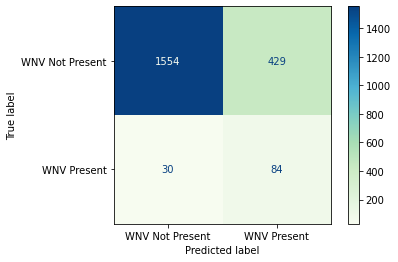

In [11]:
score(grid_rf, X_train_t, X_test_t)

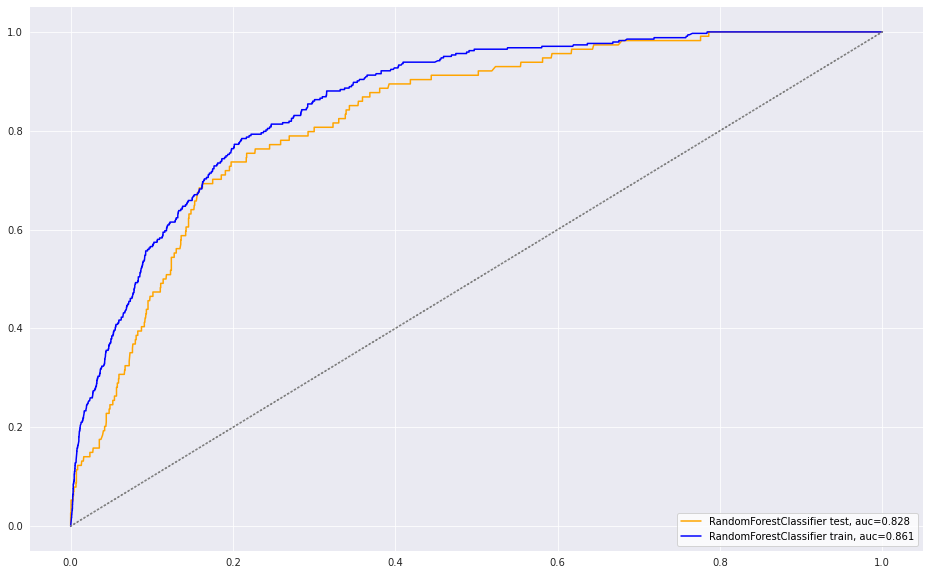

In [12]:
roc(grid_rf,"RandomForestClassifier", X_train_t, X_test_t)

### Scoring

As shown above, Random Forest Classifier performs fairly well with a test accuracy of 82.8%. However, a train score of 86.1% suggest some overfit in the training set.

In terms of classification report, precision and recall scores of predicting the true presence of West Nile Virus is significantly lower than predicting the lack of presence. Therefore, it is better that we predict where the West Nile Virus is more likely to be absent and plan for sprays inversely.

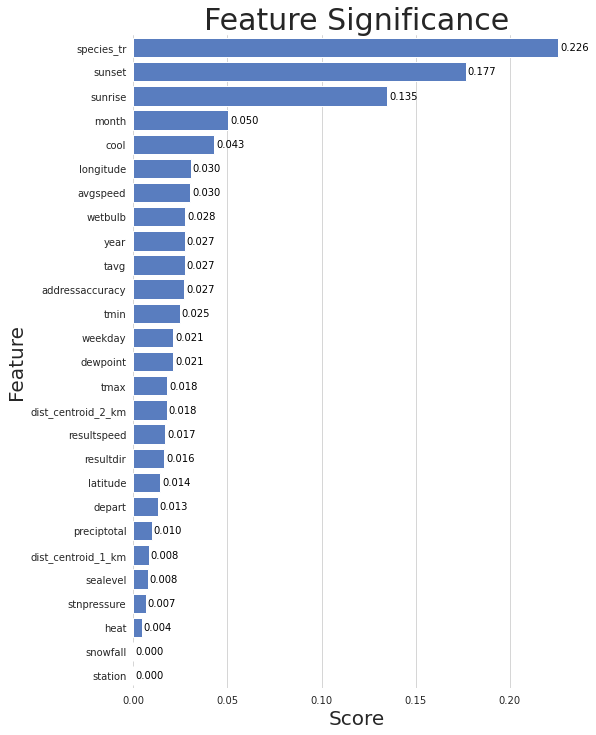

In [13]:
rf_score = grid_rf.best_estimator_.named_steps.randomforestclassifier.feature_importances_
fimportance(X_train_t.columns.to_list(), rf_score)

### Feature Significance

As shown in the bar plot above, the top 3 features are significantly more important than the rest. As expected, the species of mosquitos are among the top features and it is expected as explored during EDA.

`Sunrise` and `sunset` that were merged from the weather data also proved to be significant, and correlated to these are the rest of the weather data that is derived from temperature. 

`Month` is also a significant feature, as explored in EDA, as positive cases tend to be clustered in the summer months.

## Logistic Regression

Similar to the random forest model, we would also need to deal with imbalanced data. Here we deal with it using SMOTE, and then passing min max scaler to scale the data before modelling.

In [14]:
# create modelling pipeline with SMOTE to deal with imbalanced classes

lr_pipe = make_pipeline(SMOTE(random_state=random_state),
                        MinMaxScaler(),
                           
                           ### Insert Model here for future modelling ###
                           
                           LogisticRegression(max_iter=200,random_state=random_state)
                          )


# define grid params for logistic regression
lr_params = {
    'logisticregression__C': [0.02, 0.05, 0.1],
    'logisticregression__solver' : ['newton-cg','saga', 'sag', 'lbfgs'],
    'logisticregression__multi_class': ['multinomial', 'ovr', 'auto'],
    'logisticregression__penalty':['l1','l2','elasticnet'],
    'logisticregression__l1_ratio':[None, 0.25,0.5,0.75],
    'logisticregression__class_weight':[None, 'balanced']
}

# Instantiate GridSearchCV
# Due to imbalanced data, scoring = roc & auc
grid_lr = GridSearchCV(lr_pipe, param_grid = lr_params, verbose = 1, n_jobs=-1, cv=5, scoring='roc_auc')

In [15]:
grid_lr.fit(X_train_t,y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=RandomState(MT19937) at 0x27251643C40)),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=200,
                                                           random_state=RandomState(MT19937) at 0x27251643C40))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.02, 0.05, 0.1],
                         'logisticregression__class_weight': [None, 'balanced'],
                         'logisticregression__l1_ratio': [None, 0.25, 0.5,
                                                          0.75],
                         'logisticregression__multi_class': ['multinomial',
                                                             'ovr', 'auto'],
                         'logisticregressi

In [16]:
print("best score", grid_lr.best_score_)
print("best params", grid_lr.best_params_)

best score 0.8064714256208765
best params {'logisticregression__C': 0.1, 'logisticregression__class_weight': None, 'logisticregression__l1_ratio': None, 'logisticregression__multi_class': 'multinomial', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}


Training Score: 0.8178492132397892
Testing Score: 0.7999265688174041


              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1983
           1       0.13      0.73      0.23       114

    accuracy                           0.73      2097
   macro avg       0.56      0.73      0.53      2097
weighted avg       0.93      0.73      0.80      2097



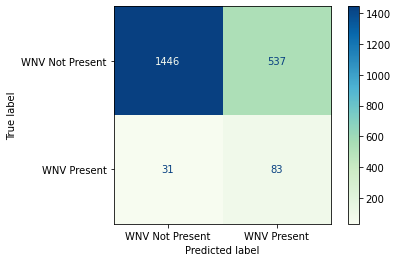

In [17]:
score(grid_lr, X_train_t, X_test_t)

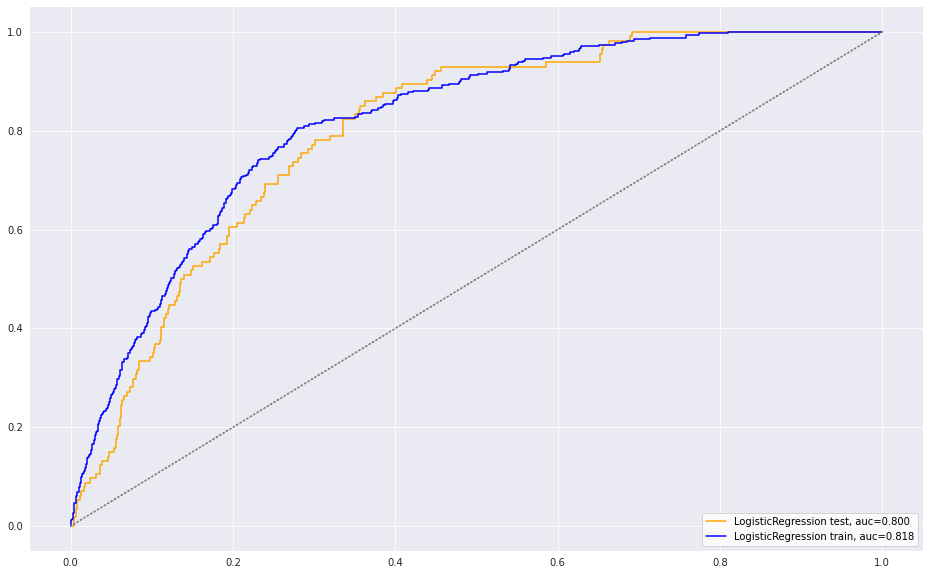

In [18]:
roc(grid_lr,"LogisticRegression", X_train_t, X_test_t)

### Scoring

Compared against the random forest model, logistic regression offers lower accuracy, but also a much lower variance; the model is not overfitted, although its accuracy is not as high.

Similar to the random forest classifier, precision score at predicting the presence of West Nile Virus leaves much to be desired. Interestingly, the recall score of both classes are similar.

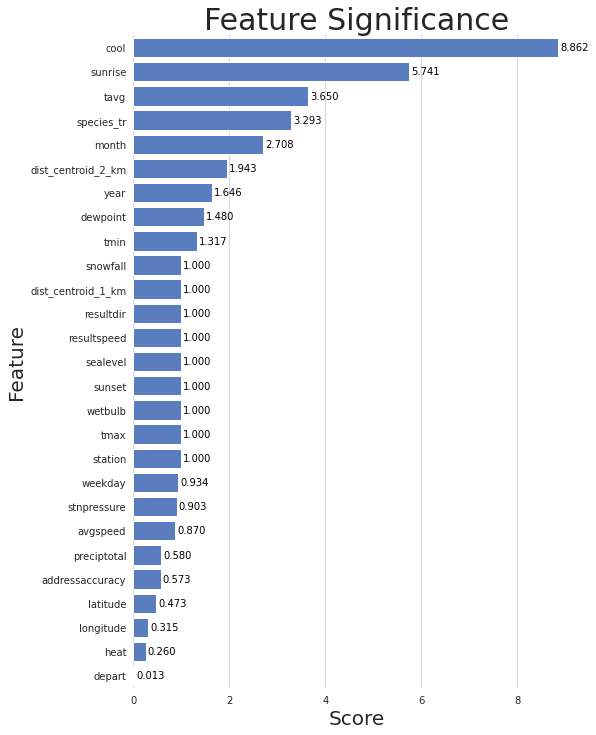

In [19]:
lr_score = grid_lr.best_estimator_.named_steps.logisticregression.coef_
lr_score2 = [np.exp(i) for i in lr_score[0]]
fimportance(X_train_t.columns.to_list(), lr_score2)

### Feature Significance

The top few features are similar to random forest model in terms of the weather & temperature based features. In this model, the preferred location metric is distances to centroids. They are rated higher than they are in the random forest model, which prefers longitude feature.

## Gradient Boost

The third model used is gradient boost. This is another tree-based model and can be considered as an extension to the random forest model.

SMOTE is used to deal with imbalanced data.

In [20]:
# create modelling pipeline with SMOTE to deal with imbalanced classes

gb_pipe = make_pipeline(SMOTE(random_state=random_state),
                           
                           ### Insert Model here for future modelling ###
                           
                           GradientBoostingClassifier(random_state=random_state,
                                                      n_iter_no_change=3)
                          )


# define grid params for gradient boosting
gb_params = {
    'gradientboostingclassifier__learning_rate': [0.1, 0.2, 0.3],
    'gradientboostingclassifier__criterion' : ['friedman_mse','mse'],
    'gradientboostingclassifier__n_estimators': [20,50,100],
    'gradientboostingclassifier__max_features':['sqrt','log2'],
    'gradientboostingclassifier__loss':['deviance','exponential']
}

        
# Instantiate GridSearchCV
# Due to imbalanced data, scoring = roc & auc
grid_gb = GridSearchCV(gb_pipe, param_grid = gb_params, verbose = 1, n_jobs=-1, cv=5, scoring='roc_auc')

In [21]:
grid_gb.fit(X_train_t,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=RandomState(MT19937) at 0x27251643C40)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(n_iter_no_change=3,
                                                                   random_state=RandomState(MT19937) at 0x27251643C40))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__criterion': ['friedman_mse',
                                                                   'mse'],
                         'gradientboostingclassifier__learning_rate': [0.1, 0.2,
                                                                       0.3],
                         'gradientboostingclassifier__loss': ['deviance',
                                                              'exponential'],
                         'gradientboostingclassifier__max_fe

In [22]:
print("best score", grid_gb.best_score_)
print("best params", grid_gb.best_params_)

best score 0.838973257725694
best params {'gradientboostingclassifier__criterion': 'friedman_mse', 'gradientboostingclassifier__learning_rate': 0.3, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__max_features': 'log2', 'gradientboostingclassifier__n_estimators': 100}


Training Score: 0.9173400509162324
Testing Score: 0.8478625332873282


              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1983
           1       0.25      0.46      0.32       114

    accuracy                           0.89      2097
   macro avg       0.61      0.69      0.63      2097
weighted avg       0.93      0.89      0.91      2097



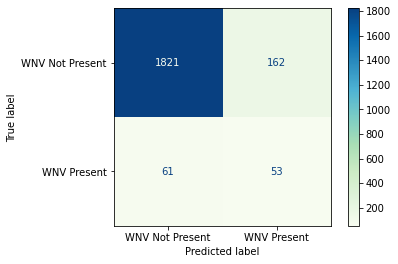

In [23]:
score(grid_gb, X_train_t, X_test_t)

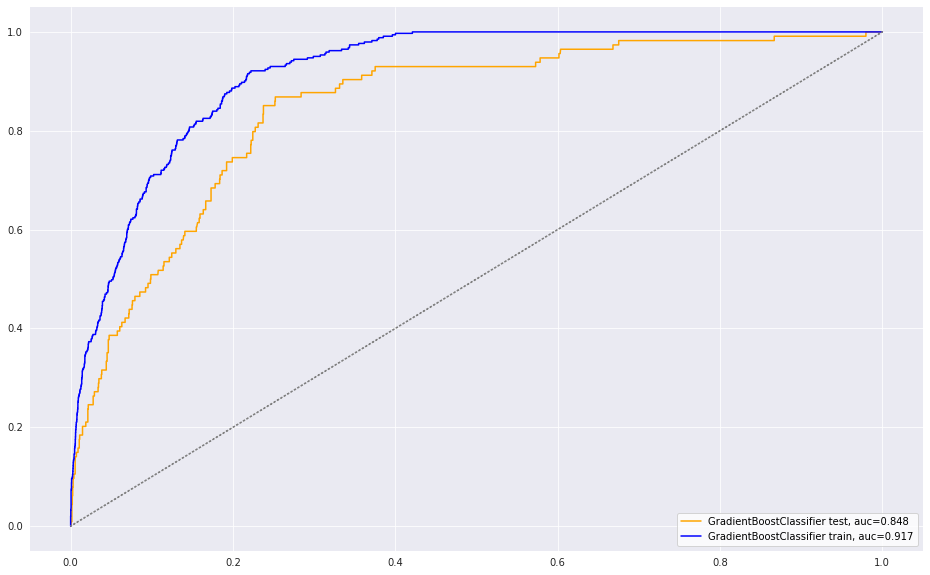

In [24]:
roc(grid_gb,"GradientBoostClassifier", X_train_t, X_test_t)

### Scoring

The AUC score of the gradient boost model is the highest among the 3 models, but its variance is also the highest.

Precision and Recall scores for class 1 are abysmal. Perhaps more tuning is required for this model.

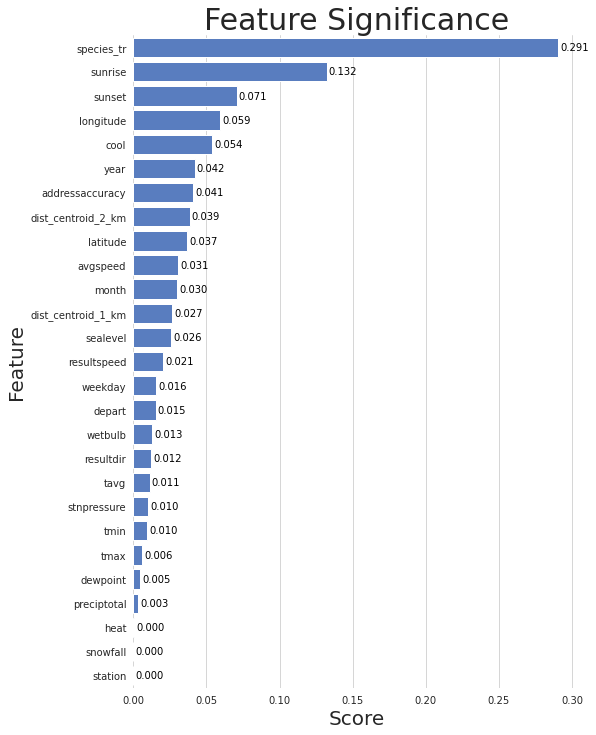

In [25]:
gb_score = grid_gb.best_estimator_.named_steps.gradientboostingclassifier.feature_importances_

fimportance(X_train_t.columns.to_list(),gb_score)

### Feature Significance

The features rank similarly to random forest model. Species of mosquito takes a very high weightage, double of the 2nd place feature of sunrise.

## Bias-Variance Tradeoff for Logistic Regression

In order to further reduce the variance between the train and test scores, we will tune and simplify the model.

Here we will take the results of the initial model in terms of the top 10 features, and generate a new model with only the top 10 features.

Similar to the prior logistic regression model, activation of the pipeline includes SMOTE for oversampling, scaling the data, followed by the model itself.

In [26]:
# Creating a new data set with only the top 10 features of the gradient boost model
features = fimportance_df(X_train_t.columns.to_list(),lr_score2)[:10]['Feature'].to_list()

# X set with filtered features
X_train_t2 = X_train_t[features]
X_test_t2 = X_test_t[features]

In [27]:
lr2_pipe = make_pipeline(SMOTE(random_state=random_state),
                        MinMaxScaler(),
                           
                           ### Insert Model here for future modelling ###
                           
                           LogisticRegression(max_iter=200, random_state=random_state)
                          )


# define grid params for logistic regression
lr2_params = {
    'logisticregression__C': [0.02, 0.05, 0.1],
    'logisticregression__solver' : ['newton-cg','saga', 'sag', 'lbfgs'],
    'logisticregression__multi_class': ['multinomial', 'ovr', 'auto'],
    'logisticregression__penalty':['l1','l2','elasticnet'],
    'logisticregression__l1_ratio':[None, 0.25,0.5,0.75],
    'logisticregression__class_weight':[None, 'balanced']
}

# Instantiate GridSearchCV
# Due to imbalanced data, scoring = roc & auc
grid_lr2 = GridSearchCV(lr2_pipe, param_grid = lr2_params, verbose = 1, n_jobs=-1, cv=5, scoring='roc_auc')

In [28]:
grid_lr2.fit(X_train_t2,y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=RandomState(MT19937) at 0x27251643C40)),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=200,
                                                           random_state=RandomState(MT19937) at 0x27251643C40))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.02, 0.05, 0.1],
                         'logisticregression__class_weight': [None, 'balanced'],
                         'logisticregression__l1_ratio': [None, 0.25, 0.5,
                                                          0.75],
                         'logisticregression__multi_class': ['multinomial',
                                                             'ovr', 'auto'],
                         'logisticregressi

In [29]:
print("best score", grid_lr.best_score_)
print("best params", grid_lr.best_params_)

best score 0.8064714256208765
best params {'logisticregression__C': 0.1, 'logisticregression__class_weight': None, 'logisticregression__l1_ratio': None, 'logisticregression__multi_class': 'multinomial', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}


Training Score: 0.7567825804323026
Testing Score: 0.7532491086516088


              precision    recall  f1-score   support

           0       0.97      0.67      0.79      1983
           1       0.11      0.68      0.18       114

    accuracy                           0.67      2097
   macro avg       0.54      0.68      0.49      2097
weighted avg       0.93      0.67      0.76      2097



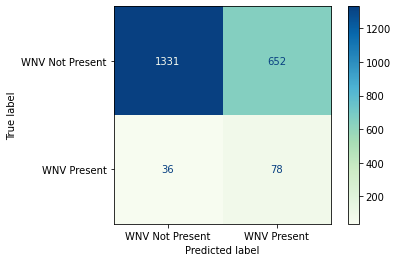

In [30]:
score(grid_lr2, X_train_t2, X_test_t2)

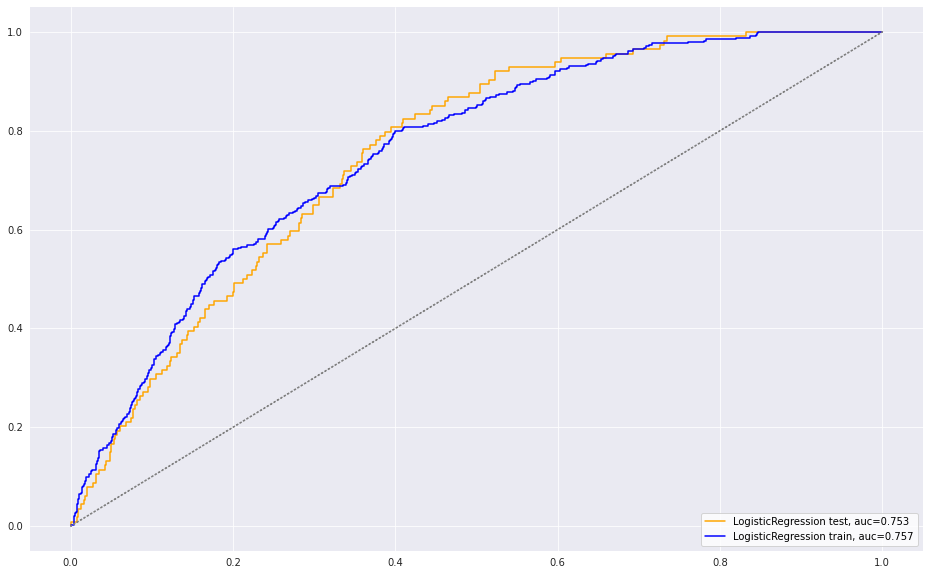

In [31]:
roc(grid_lr2,"LogisticRegression", X_train_t2, X_test_t2)

### Scoring

There is a significant drop of about 0.05 in the AUC score. However, the variance further drops, closing the gap between train and test scores at 0.004. This was not a good adjustment to the logistic regression model.

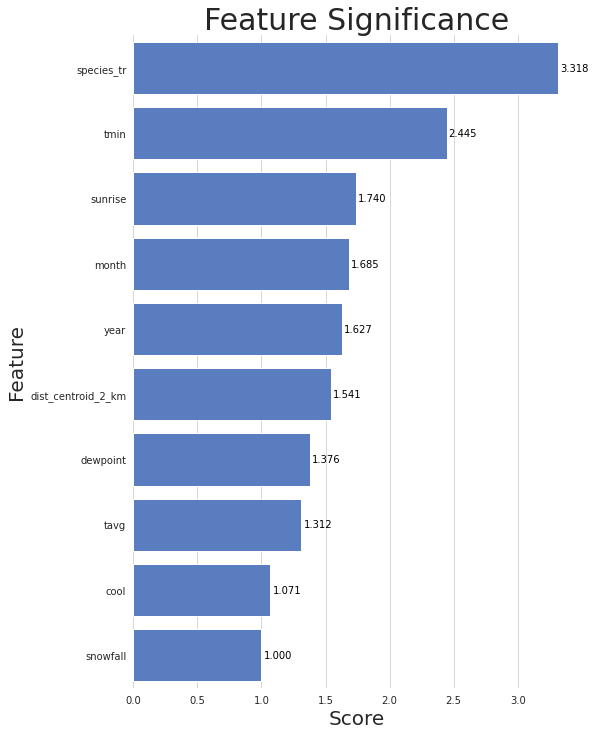

In [32]:
lr_score3 = grid_lr2.best_estimator_.named_steps.logisticregression.coef_
lr_score4 = [np.exp(i) for i in lr_score3[0]]
fimportance(X_train_t2.columns.to_list(), lr_score4)

### Feature Significance

`species_tr` is now the leading feature by coefficient. One thing to note is that due to having many tied coefficients, the code clips at `snowfall` where the coefficient value of 1 is actually tied to many features. This may also affect the overall AUC score.

## Bias-Variance Tradeoff for Gradient Boost

Since random forest and gradient boost are both tree-based models and both produced similar results, we will only pursue further modelling with the gradient boost model, where the variance is higher and there is more potential tuning.

Similarly, activation pipeline includes SMOTE, followed by gradient boost classifier.

In [33]:
# Creating a new data set with only the top 10 features of the gradient boost model

features = fimportance_df(X_train_t.columns.to_list(),gb_score)[:10]['Feature'].to_list()

# X set with filtered features
X_train_t1 = X_train_t[features]
X_test_t1 = X_test_t[features]

# create modelling pipeline with SMOTE to deal with imbalanced classes

gb_pipe1 = make_pipeline(SMOTE(random_state=random_state),
                           
                           ### Insert Model here for future modelling ###
                           
                           GradientBoostingClassifier(random_state=random_state,
                                                      n_iter_no_change=1)
                          )


# define grid params for gradient boosting
gb_params1 = {
    'gradientboostingclassifier__learning_rate': [0.1, 0.2, 0.3],
    'gradientboostingclassifier__criterion' : ['friedman_mse','mse'],
    'gradientboostingclassifier__n_estimators': [10,20,30],
    'gradientboostingclassifier__max_features':['sqrt','log2'],
    'gradientboostingclassifier__loss':['deviance','exponential']
}

        
# Instantiate GridSearchCV
# Due to imbalanced data, scoring = roc & auc
grid_gb1 = GridSearchCV(gb_pipe1, param_grid = gb_params1, verbose = 1, n_jobs=-1, cv=5, scoring='roc_auc')

In [34]:
grid_gb1.fit(X_train_t1, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(random_state=RandomState(MT19937) at 0x27251643C40)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(n_iter_no_change=1,
                                                                   random_state=RandomState(MT19937) at 0x27251643C40))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__criterion': ['friedman_mse',
                                                                   'mse'],
                         'gradientboostingclassifier__learning_rate': [0.1, 0.2,
                                                                       0.3],
                         'gradientboostingclassifier__loss': ['deviance',
                                                              'exponential'],
                         'gradientboostingclassifier__max_fe

In [35]:
print("best score", grid_gb1.best_score_)
print("best params", grid_gb1.best_params_)

best score 0.8256152708642602
best params {'gradientboostingclassifier__criterion': 'friedman_mse', 'gradientboostingclassifier__learning_rate': 0.2, 'gradientboostingclassifier__loss': 'exponential', 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__n_estimators': 30}


Training Score: 0.8684325732503
Testing Score: 0.8331453318116269


              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1983
           1       0.20      0.64      0.30       114

    accuracy                           0.84      2097
   macro avg       0.59      0.75      0.61      2097
weighted avg       0.93      0.84      0.88      2097



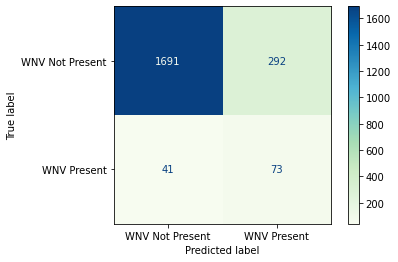

In [36]:
score(grid_gb1, X_train_t1, X_test_t1)

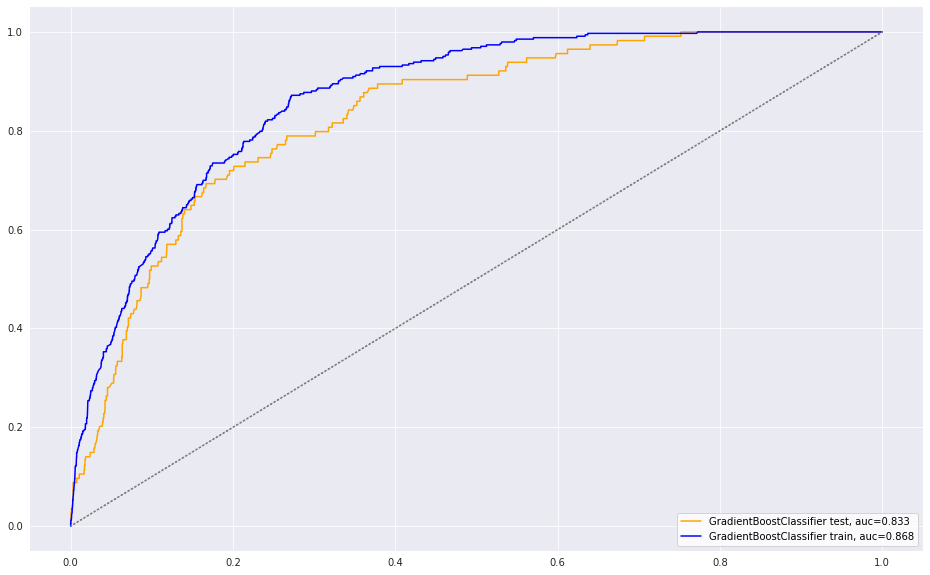

In [37]:
roc(grid_gb1,"GradientBoostClassifier", X_train_t1, X_test_t1)

### Scoring

Here we can see an improvement in terms of bias variance tradeoff. Gap between the train and test scores has shrunk from 0.07 to 0.03. AUC score, however, has dropped by about 0.01.

Precision and recall for predicting the presence of West Nile Virus is still significantly lower than predicting the absence of West Nile Virus, but there is a notable improvement in the recall score for class 1.

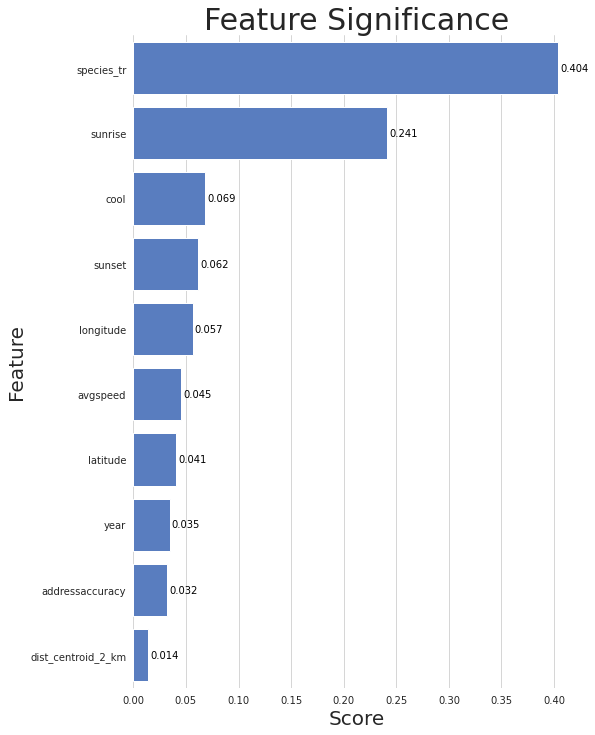

In [38]:
gb_score1 = grid_gb1.best_estimator_.named_steps.gradientboostingclassifier.feature_importances_

fimportance(X_train_t1.columns.to_list(),gb_score1)

### Feature Significance

Here we can observe that feature importances are largely the same, except for `weekday` that had dropped 2 places.

## Kaggle Submission

In [39]:
test = pd.read_csv("./asset/full_test.csv",index_col='Unnamed: 0')
#test.drop(["id","trap"],axis=1,inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116293 entries, 2008-06-11 to 2014-10-02
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               116293 non-null  int64  
 1   species          116293 non-null  object 
 2   trap             116293 non-null  object 
 3   latitude         116293 non-null  float64
 4   longitude        116293 non-null  float64
 5   addressaccuracy  116293 non-null  int64  
 6   station          116293 non-null  int64  
 7   tmax             116293 non-null  int64  
 8   tmin             116293 non-null  int64  
 9   tavg             116293 non-null  int64  
 10  depart           116293 non-null  int64  
 11  dewpoint         116293 non-null  int64  
 12  wetbulb          116293 non-null  int64  
 13  heat             116293 non-null  int64  
 14  cool             116293 non-null  int64  
 15  sunrise          116293 non-null  int64  
 16  sunset           116293 non-nu

In [40]:
test=preprocess_pipe.transform(test)

In [41]:
# Using our tuned gradient boost model to predict
proba = grid_gb1.predict_proba(test[features]) # features refer to the top 10 features picked for our gradient boosted model

In [42]:
# Create new dataframe for kaggle submission
kaggle_submission = pd.DataFrame(proba)
kaggle_submission.head()

,0,1
0,0.990247,0.009753
1,0.996341,0.003659
2,0.991982,0.008018
3,0.996341,0.003659
4,0.996341,0.003659


In [43]:
test_index = test['id']
test_index.reset_index(drop=True,inplace=True)

# create Id column
kaggle_submission["Id"] = test_index

# Map 1 as WnvPresent as per submission requirement
kaggle_submission.rename(columns={1:"WnvPresent"},inplace=True)
kaggle_submission[["Id","WnvPresent"]].head()

,Id,WnvPresent
0,1,0.009753
1,2,0.003659
2,3,0.008018
3,4,0.003659
4,5,0.003659


In [44]:
# Export to submit
kaggle_submission[["Id","WnvPresent"]].to_csv("./asset/kaggle.csv",index=False)

The model performs well, predicting well above the baseline of 0.5. However, it is still rather overfitted:
<img src="./asset/results.png">

## Conclusion

### Cost Benefit Analysis

#### Factors taken into consideration for cost analysis:

1. Cost impact of West Nile Virus
2. Fixed costs for vector control (i.e transportation fees, human resource, etc)
3. Variable costs for vector control (i.e. insecticide, fuel costs, etc)
4. Effectiveness of of spraying is 100%

#### Key Assumptions:

Based on the above mentioned factors, several assumptions were taken for this cost benefit analysis:

1. Annual inflation is not taken into consideration.
2. Medical treatment cost for Sacramento county is same as for the city of Chicago
3. Breakdown of Cost of Spraying is 50% fixed cost and 50% variable cost

Given the data from Sacramento's case study, the following conclusions were drawn:

| Breakeven Table                               | unit      | Best Case  Scenario | 25% of Chicago  Area | 50% of Chicago  Area | 75% of Chicago  Area | Worst Case  Scenario (100%) |
| :-------------------------------------------- | :---------: | :-----------------: | :------------------: | :------------------: | :------------------: | :-------------------------: |
| Infected Area                                 | km²       |          1          |        147.5         |         295          |        442.5         |             590             |
| Fixed Cost per  Spray (A)                     | \$         |       351,631       |       351,631        |       351,631        |       351,631        |           351,631           |
| Variable Cost  per spray (B)                  | \$         |         736         |       108,505        |       217,011        |       325,516        |           434,021           |
| Total Spray  Cost (A + B)                     | \$         |       352,366       |       460,136        |       568,641        |       677,146        |           785,652           |
| Treament Cost  per Case (C )                  | \$         |       49,565        |        49,565        |        49,565        |        49,565        |           49,565            |
| Cases Required to break even     ( A+ B ) / C | No. Cases |          8          |          10          |          12          |          14          |             16              |

### Future Recommendation

We could further improve upon the prediction with several exploratory solutions:

1. Perform more hyperparameter tuning
2. Using spray data to create additional features
3. Creating another model to predict "nummosquitos" as a feature (preliminary modelling of the training set suggest that this was the single most important feature, but was later dropped due to its absence in test.csv)
4. Gather more external data such as population density by neighbourhood to create a more detailed cost benefit analysis